In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # 데이터 시각화
import seaborn as sns
import missingno as msno
import os
import re
import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool 
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from data_loader_v2 import data_loader_v2

%matplotlib inline
plt.rcParams["figure.figsize"] = (13,10)

In [68]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Embedding
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import np_utils
import keras
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
seed = 777

In [1]:
## 실제 데이터 로드
realData1 = "Train/30.csv"
realData2 = "Test/1154.csv"
realData3 = "Test/1168.csv"
realData4 = "additinal_data/additinal_data1"
realData5 = "additinal_data/additinal_data2"

In [6]:
## 데이터 Path
train_folder = 'train/'
test_folder = 'test/'
train_label_path = 'train_label.csv'
train_list = os.listdir(train_folder)
test_list = os.listdir(test_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

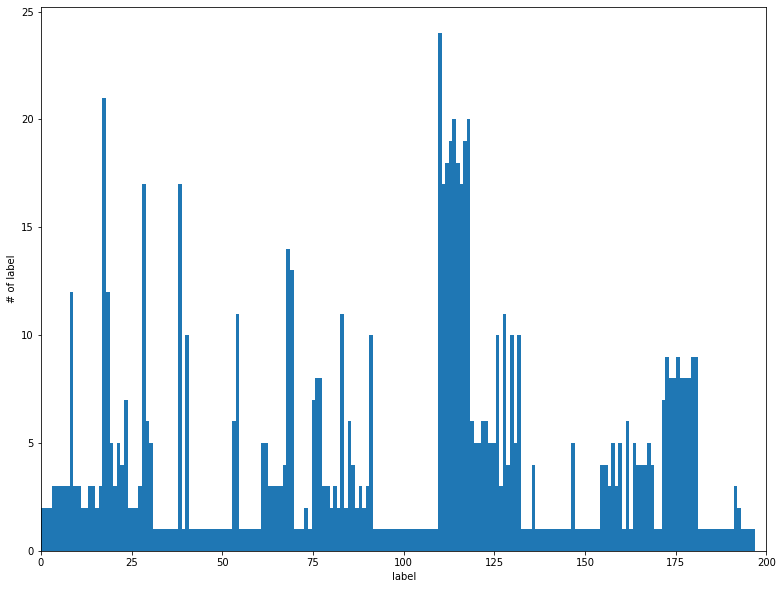

총 데이터의 개수 :  828


In [50]:
# Dacon 토론에서 공개된 Label당 Imbalance Data 분포도
train_l = pd.read_csv("train_label.csv")
plt.hist(train_l['label'], bins=len(train_l['label'].unique()))
plt.xlim(0,200)
plt.ylim(bottom=0)
plt.xlabel('label')
plt.ylabel('# of label')
plt.show()
print("총 데이터의 개수 : ",len(train_l['label']))
list = []
for i in range(len(train_l['label'].unique())):
    list.append(len(train_l[:][train_l['label']==i]))

# Data Preprocessing 

In [7]:
# 모든 csv 파일의 상태_B로 변화는 시점이 같다라고 가정, 10초
# 하지만, 개별 csv파일의 상태_B로 변화는 시점은 상이할 수 있음, 60개의 row만 보기, 즉 10~60초의 시간만 학습
# Dacon baseline으로 지정해주는 데이터 로드 함수
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=10, nrows=60):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df

In [8]:
# Dacon에서 제공해주는 함수를 이용한 데이터 Merge와 csv 저장 및 불러오기
#train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=10, nrows=60)
#train.to_csv("base_train.csv")
train = pd.read_csv("base_train.csv", index_col='Unnamed: 0')

#test = data_loader_all_v2(data_loader_v2, test_list, folder=test_folder, train_label=None, event_time=10, nrows=60)
#test.to_csv("base_test.csv")
test = pd.read_csv("base_test.csv", index_col='Unnamed: 0')

In [51]:
# Data에 대해 y = label 과 trainData 분리
train_c = train.copy()
train_label = train_c['label']
train_data = train_c.drop(['label'], axis=1)

In [11]:
# Data에 대해 train과 검증 데이터 분리
X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=seed)
print(X_train,X_val,Y_train,Y_val)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

         V0000     V0001     V0002     V0003     V0004       V0005  \
666  30.460902  8.696729  8.678150  8.707048  8.743941  187.271493   
675  30.467751  8.634908  8.721089  8.677828  8.720551  208.165981   
547  30.473759  8.729892  8.689503  8.666899  8.672289  253.143294   
248  30.484401  8.759098  8.716958  8.730716  8.687358  178.700974   
389  30.469542  8.785799  8.717737  8.735726  8.717749  176.454884   
..         ...       ...       ...       ...       ...         ...   
811  23.635265  4.311902  4.222889  3.817453  3.780163  -23.022390   
317  30.477458  8.750068  8.722127  8.723330  8.707557  196.777031   
589  30.470703  8.831234  8.686700  8.706548  8.714215  187.066875   
819  30.446290  8.736160  8.680907  8.678161  8.692547  279.684095   
525  30.476703  8.689716  8.664188  8.677084  8.653015  239.878768   

          V0006         V0007  V0008       V0009  ...  V5111  V5112  V5113  \
666  220.187777 -2.609061e-19    0.0   -0.000446  ...    1.0    1.0    1.0   
675

In [84]:
# Datapreprocessing 중 스케일링 진행 / RobuestScaling 사용
robustScaler = RobustScaler()
train_data_rob = pd.DataFrame(robustScaler.fit_transform(train_data), columns=train_data.columns, index = train_data.index.values)
test_rob = pd.DataFrame(robustScaler.fit_transform(test), columns=test.columns, index = test.index.values)

X_train_rob, X_test_rob, Y_train_rob, Y_test_rob = train_test_split(train_data_rob, train_label, test_size=0.2, random_state=seed)
print(X_train_rob,X_test_rob,Y_train_rob,Y_test_rob)
print(X_train_rob.shape,X_test_rob.shape,Y_train_rob.shape,Y_test_rob.shape)

          V0000      V0001       V0002       V0003       V0004     V0005  \
666   -0.686373  -0.258664   -0.966421    0.070733    1.182847 -0.324421   
675   -0.259886  -0.833324    0.597189   -0.600461    0.460626  0.558946   
547    0.114254   0.049602   -0.553022   -0.851495   -1.029616  2.460476   
248    0.776996   0.321080    0.446751    0.614380   -0.564326 -0.686762   
389   -0.148344   0.569288    0.475110    0.729478    0.374098 -0.781721   
..          ...        ...         ...         ...         ...       ...   
811 -425.761128 -41.017939 -163.205259 -112.244763 -152.089454 -9.215128   
317    0.344627   0.237146    0.634973    0.444730    0.059377  0.077449   
589   -0.076033   0.991626   -0.655079    0.059241    0.264972 -0.333072   
819   -1.596356   0.107864   -0.866058   -0.592821   -0.404099  3.582555   
525    0.297606  -0.323860   -1.474858   -0.617546   -1.624753  1.899684   

        V0006         V0007  V0008          V0009  ...  V5111  V5112  V5113  \
666  0.6

# SMOTE

In [55]:
smote = SMOTE()
train_data_sm , train_label_sm = smote.fit_sample(train_data, train_label)

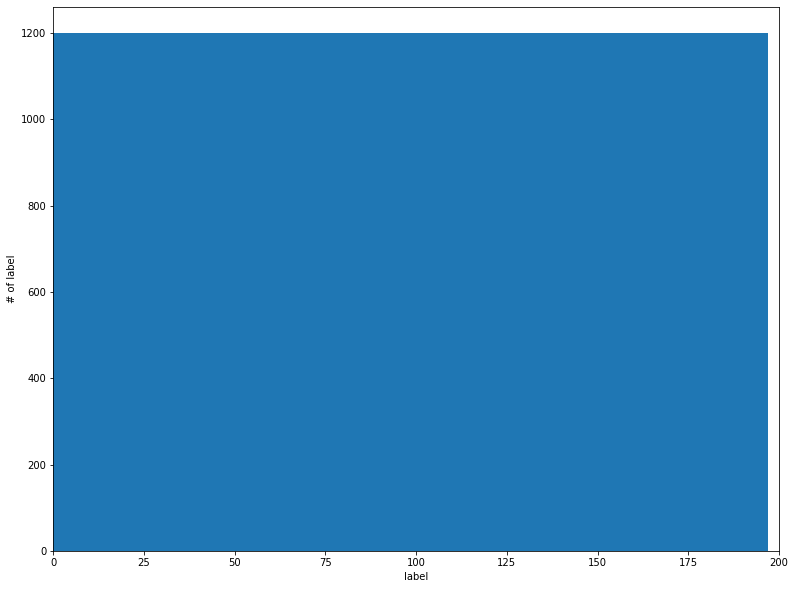

In [59]:
plt.hist(train_label_sm, bins=len(train_label_sm.unique()))
plt.xlim(0,200)
plt.ylim(bottom=0)
plt.xlabel('label')
plt.ylabel('# of label')
plt.show()

# RandomForest 

In [63]:
model_smote_rf = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
model_smote_rf.fit(train_data_sm, train_label_sm)
pred = model_smote_rf.predict_proba(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 39.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished


In [65]:
submission = pd.DataFrame(data=pred)
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('submission_baseline_4.csv', index=True) #제출 파일 만들기

In [69]:
# LeaderBoard : 17:08:09 0.8885022881
#joblib.dump(model_smote_rf, 'smote_rf_model.pkl')

['smote_rf_model.pkl']

In [ ]:
model_smote_rf = joblib.load('lgbmodel.pkl')

# DNN Model 

In [103]:
encoder = LabelEncoder()
encoder.fit(train_label)
encoded_Y = encoder.transform(train_label)
dummy_y = np_utils.to_categorical(encoded_Y)

In [104]:
def make_DNN():
    model = Sequential([
    Dense(1024, input_dim=5121, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(198, activation='softmax')])
    return model

In [105]:
model_DNN = make_DNN()
model_DNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              5244928   
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_24 (Dense)             (None, 198)               50886     
Total params: 5,951,942
Trainable params: 5,951,942
Non-trainable params: 0
_________________________________________________________________


In [108]:
keras.initializers.he_normal()
model_DNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model_DNN.fit(train_data_rob, dummy_y, batch_size=10, epochs=50)

Epoch 1/50
 1720/41400 [>.............................] - ETA: 6:33 - loss: nan - accuracy: 0.0023

KeyboardInterrupt: 

In [ ]:

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
